# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

Prepare the ICS transfer functions from these files.

In [4]:
eleceng = 10**np.arange(0, 12, 0.04)
photeng = 10**np.arange(-4, 12, 0.04)
T = 10

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

print(eleceng.size, photeng.size)

300 400


Check that everything is working as expected...

[0.0001, 10000000000000.0, 1e-16, 1000.0]

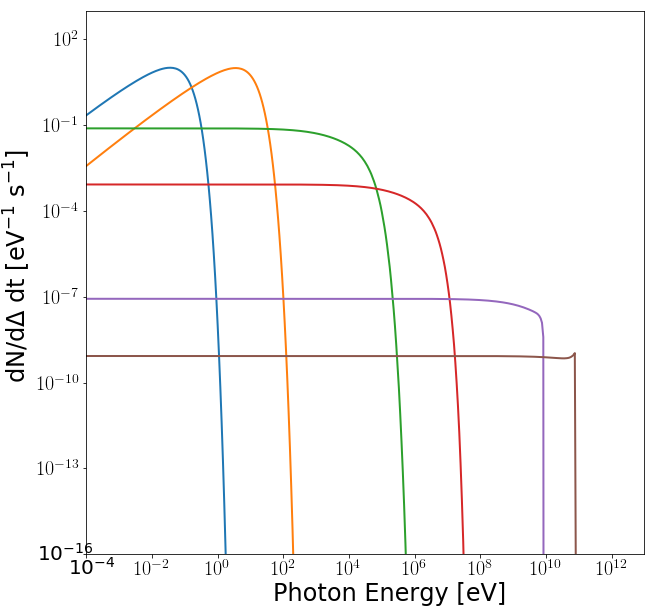

In [5]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/d$\Delta$ dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [6]:
sec_elec_tf = copy.deepcopy(engloss_tf)

for in_eng, spec in zip(sec_elec_tf.get_in_eng(), sec_elec_tf):
    spec.engloss_rebin(in_eng, sec_elec_tf.get_in_eng())

[0.0001, 10000.0, 1e-16, 1000.0]

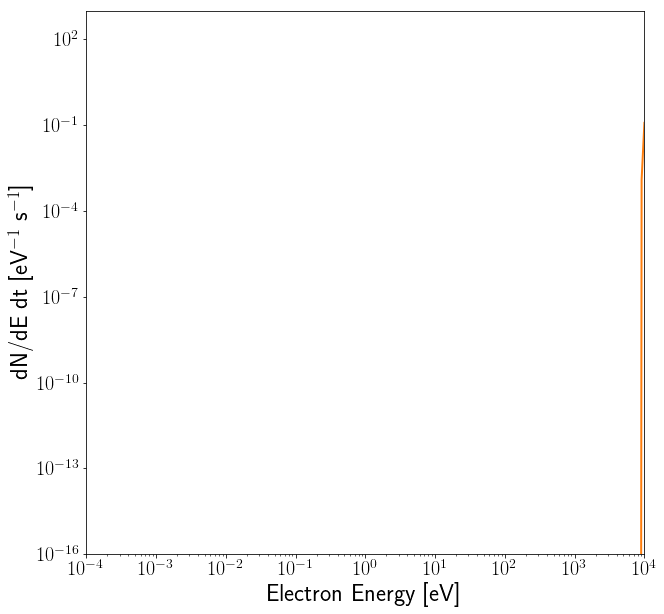

In [7]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

sec_elec_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Electron Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e4, 1e-16, 1e3])

In [14]:
%%prun
sec_phot_tf = tf.TransFuncAtRedshift([], dlnz=-1)
sec_phot_tf.rs = ICS_tf.rs
lowengelec_tf = tf.TransFuncAtRedshift([], dlnz=-1)
lowengelec_tf.rs = ICS_tf.rs
elec_high_eng = eleceng[eleceng > 3000]
elec_low_eng  = eleceng[eleceng <= 3000]

highengelec_ind = np.arange(eleceng.size)[eleceng > 3000]
lowengelec_ind  = np.arange(eleceng.size)[eleceng <= 3000]

ICS_tf_high_eng = ICS_tf.at_in_eng(highengelec_ind, interp_type='bin')

sec_elec_tf_high_eng = sec_elec_tf.at_val(
    highengelec_ind, highengelec_ind, interp_type='bin'
)

sec_elec_tf_low_eng = sec_elec_tf.at_val(
    highengelec_ind, lowengelec_ind, interp_type='bin'
)

for i,eng in zip(np.arange(elec_high_eng.size), elec_high_eng):
    delta_spec = np.zeros_like(elec_high_eng)
    delta_spec[i] = 1
    sec_phot_spec = spectools.scatter(ICS_tf_high_eng, mode='N', 
                                      eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=photeng)
    sec_elec_spec = spectools.scatter(sec_elec_tf_high_eng, mode='N',
                                      eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=elec_high_eng)
    sec_elec_spec.in_eng = eng
    sec_lowengelec_spec = spectools.scatter(sec_elec_tf_low_eng, mode='N',
                                            eng_arr = elec_high_eng, N_arr = delta_spec, new_eng=elec_low_eng)
    sec_lowengelec_spec.in_eng = eng
    if sec_phot_tf.spec_arr and i > 1:
        rescatter_spec = Spectrum(sec_elec_spec.eng[0:i], sec_elec_spec.dNdE[0:i], rs=sec_elec_spec.rs)
        ICS_tf_elec_sec = ICS_tf.at_in_eng(highengelec_ind[0:i], interp_type='bin')
        sec_phot_spec += spectools.scatter(ICS_tf_elec_sec, mode='dNdE', spec=rescatter_spec, new_eng=photeng)
    sec_phot_spec.in_eng = eng
    sec_phot_tf.append(sec_phot_spec)
    lowengelec_tf.append(sec_lowengelec_spec)
    
        
        
        
    

In [9]:
print(sec_phot_tf.get_in_eng())
print(sec_phot_tf.get_eng())
test2 = sec_phot_tf.at_in_eng([1e4])
utils.compare_arr([test2.get_eng(),test2.get_grid_values().flatten()])

[  3.01995172e+03   3.31131121e+03   3.63078055e+03   3.98107171e+03
   4.36515832e+03   4.78630092e+03   5.24807460e+03   5.75439937e+03
   6.30957344e+03   6.91830971e+03   7.58577575e+03   8.31763771e+03
   9.12010839e+03   1.00000000e+04   1.09647820e+04   1.20226443e+04
   1.31825674e+04   1.44543977e+04   1.58489319e+04   1.73780083e+04
   1.90546072e+04   2.08929613e+04   2.29086765e+04   2.51188643e+04
   2.75422870e+04   3.01995172e+04   3.31131121e+04   3.63078055e+04
   3.98107171e+04   4.36515832e+04   4.78630092e+04   5.24807460e+04
   5.75439937e+04   6.30957344e+04   6.91830971e+04   7.58577575e+04
   8.31763771e+04   9.12010839e+04   1.00000000e+05   1.09647820e+05
   1.20226443e+05   1.31825674e+05   1.44543977e+05   1.58489319e+05
   1.73780083e+05   1.90546072e+05   2.08929613e+05   2.29086765e+05
   2.51188643e+05   2.75422870e+05   3.01995172e+05   3.31131121e+05
   3.63078055e+05   3.98107171e+05   4.36515832e+05   4.78630092e+05
   5.24807460e+05   5.75439937e+05

0

[0.0001, 10000000000000.0, 1e-16, 1000.0]

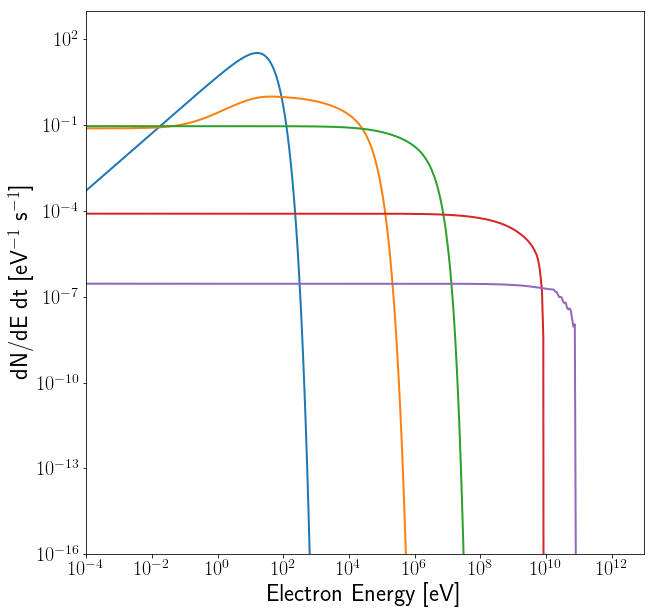

In [10]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1e4, 1e7, 1e8, 1e10, 1e11])

sec_phot_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Electron Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [11]:
a = np.array([1,2,3,4.0,5])
print(a.dtype.type)
issubclass(a.dtype.type, np.integer)

<class 'numpy.float64'>


False